ya entrenamos dos modelos de recomendacion, ahora usaremos otro enfoque para contruir la matriz de caracteristicas de las peliculas y series, utilizando herramientas de Texmining para darle mas valor descriptivo al mismo.

importamos librerias y data set, de entrenamiento y testeo

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
!pip install lightfm
vistacsr=pd.read_csv('/content/drive/MyDrive/Data Science - TP4/datos Proyecto/vistascsrPre.csv')
test=pd.read_csv('/content/drive/MyDrive/Data Science - TP4/datos Proyecto/setTesLim.csv')
activos=pd.read_csv('/content/drive/MyDrive/Data Science - TP4/datos Proyecto/metadata.csv',sep=";")
vistacsr=vistacsr.drop(columns='Unnamed: 0')
test=test.drop(columns='Unnamed: 0')#
from nltk import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer

In [ ]:
activos=activos[['asset_id', 'content_id','show_type', 'released_year', 'country_of_origin', 'category',
       'keywords','cast_first_name',
       'reduced_desc', 'audience']]

In [ ]:
activos=activos.loc[activos.content_id.dropna().index,:]


procesamos un poco el data set de los contenidos

In [ ]:
activos=activos.fillna('')

In [ ]:
for i in activos.columns:
  if activos[i].dtypes!='O':
    activos[i]=activos[i].astype(int)

In [ ]:
activos['content_id']=activos['content_id'].astype(str)

In [ ]:
activos=activos.drop(columns=['asset_id']).set_index('content_id')

In [ ]:
for i in activos.columns:
   activos[i]=activos[i].astype(str)

creamos la columna llamada texto que vamos a utilizar para crear  tecnicas de text mining

In [ ]:
activos['texto']=+activos['released_year']+' '+activos['country_of_origin']+' '+activos['keywords']+' '+activos['audience']+' '+activos['category']+' '+activos['show_type']



In [ ]:
activos=activos[['texto']]

In [ ]:
vistacsr['content_id']=vistacsr['content_id'].astype(int).astype(str)

In [ ]:
activos=activos.loc[activos.index.isin(vistacsr.set_index('content_id').index)]

agrupamos por content id, los textos duplicados los volvemos listas, que posterior mente trataremos, volviendolos a tranformar en textos, y sacandole caracteres especiales.

In [ ]:
activos=activos.groupby(by=activos.index,as_index=True)['texto'].apply(list).reset_index()

In [ ]:
activos.texto=activos.texto.apply(str).str.replace("'","").str.replace('[','').str.replace(']','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
activos=activos.set_index('content_id')

definimos una función con la cual, tokenizaremos el texto,aplicaremos stem y sacaremos del texto stop word

In [ ]:
def clean_review(review_text, tokenizer, stemmer, stopwords):    
    
    #tokens (eliminamos todos los signos de puntuación)
    words = tokenizer.tokenize(review_text)
    #print(words)
    
    # stemming: raiz y minúsculas:
    stem_words = [stemmer.stem(x) for x in words]
    #print(stem_words)
    
    # eliminamos stopwords (ya pasaron por stem)
    clean_words = [x for x in stem_words if x not in stopwords]
    #print(clean_words)
    
    result = " ".join(clean_words)
    
    return(result)

In [ ]:
#eliminamos todos los signos de puntuación
tokenizer = RegexpTokenizer(r"\w+")

españolStemmer = SnowballStemmer("spanish")
stopwords_en = stopwords.words('spanish');

In [ ]:
activosp = [clean_review(x, tokenizer, españolStemmer,stopwords_en) for x in activos.texto]

vectorizamos y normalizamos las features que usaremos para crear la matriz de caracteristicas

In [ ]:
#tf-idf  normaliza (dividir) el conteo de cada palabra por el tamaño de cada documento.
#se centra en la frecuencia de las palabras presentes en el corpus, sino que también tiene en cuenta su importancia
vectorizer=TfidfVectorizer(stop_words=stopwords_en,strip_accents='unicode');

activospt=vectorizer.fit_transform(activosp);

print('Dimensionalidad:',activospt.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

Dimensionalidad: (505, 336)


In [ ]:
del activosp

In [ ]:
len(vistacsr.content_id.unique())

505

comenzamos a crear el set de interacciones, de lightfm

In [ ]:
vistacsr=vistacsr[vistacsr.content_id.isin(activos.index)]

In [ ]:
from lightfm.data import Dataset
dataset  = Dataset()
dataset.fit(
            users=(vistacsr.loc[x,'id_unico']  for x in vistacsr.index),
            items =(vistacsr.loc[x,'content_id']  for x in vistacsr.index),
            user_features =(vistacsr.loc[x,'puntuacion']  for x in vistacsr.index)
            )
dataset

tranformamos la matriz devuelta por el tf-idf, en un dataframe de pandas para poder modelarlo de la manera adecuada para crear la matriz de caracteristicas 

In [ ]:
train = pd.DataFrame(activospt.todense(), 
             columns = vectorizer.get_feature_names(),
             index=activos.index) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
train=train.reset_index()

In [ ]:
#ahora caracteristicas
for column in train.drop(columns='content_id').columns:
  dataset.fit_partial( items=(train.loc[x,'content_id'] for x in train.index),
                    item_features=(train.loc[x,column] for x in train.index)
                    )

creamos la matriz de interacciones, caracteristicas finales, y entrenamos lightfm

In [ ]:
#contruimos la matrix de interacciones del modelo
(interactions, weights) = dataset.build_interactions( vistacsr.loc[:,['id_unico','content_id','puntuacion']].to_numpy())

In [ ]:
item_features = dataset.build_item_features(((train.loc[i,'content_id'],list(train.drop(columns='content_id').loc[i].values)) for i in train.index))

In [ ]:
from lightfm import LightFM

model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)
model.fit(interactions, item_features=item_features, epochs=100,
                  num_threads=16, verbose=False)

empezamos a evaluar el modelo entrenado, primero en train

In [ ]:
from lightfm.evaluation import precision_at_k
precision_score_train  = precision_at_k(model, interactions,item_features=item_features).mean()

In [ ]:
precision_score_train

0.14671066

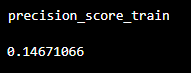

ahora evaluemos el modelo en el set de testeo, empleando la metrica denominada MAP

In [ ]:
mapeo=dataset.mapping()
user_dic=mapeo[0]
peliculas_dic=mapeo[2]
test.content_id=test.content_id.astype(int).astype(str)
test=test[test.content_id.isin(train.content_id)]

In [ ]:
#FUNCION que nos permite calcular el APS, average pressicion score
aps = [] # lista vacía para ir almacenando la AP de cada recomendación
def calculaAveragePrecision(pred,label):
  #for pred, label in zip(pred, labels):
  #print(pred, label)
  n = len(pred) # cantidad de elementos recomendados
  #print(f'n = {n}')
  arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1
  rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
  #print(f'ítems relevantes = {rel_k}')#hasta aqui estamos viendo que items de las predicciones fueron vistos realmente por el usuario
  #creamos una matris de unos con la cantidad de aciertos, luego con esta una matriz del mismo tamaño pero 
  #con la suma acumulada de aciertos 
  tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
  #print(f'contador de verdaderos positivos = {tp}')
  denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
  #print(f'posiciones de los ítems relevantes = {denom}')
  #P(k) es el promedio de la cantidad de aciertos acumuladas entre su posicion, por ejemplo#
  #acerto en la 1,3,5. el vector de aciertos acumulado es 1,2,3. luego el resultado del pk. luego
  #calculariamos el average precision ap, con este resultado, dividido entre el tamaño del vector de visualizaciones hechas
  #print(f"P(k) a promediar = {[f'{x}/{int(y)}' for (x,y) in zip(tp, denom)]}")
  ap = (tp / denom).sum() / len(label) # average precision
  #print(f'average precision = {round(ap, 3)}')
  aps.append(ap)
  #alacenamos el resultado por usuario
  #print('\n')
  return aps

In [ ]:
setCorridas=pd.DataFrame()
for id in test[test.id_unico.isin(vistacsr.id_unico)].id_unico.unique():
  #medimos unicamente los clientes en el conjunto de testeo que son las visualizaciones del
 # del mes de marzo, que vieron contenidos distintos en dicho mes, y no clientes que hallan repetido contenidos iguales, 
 # ya que esto dispararia las metricas de presicion del modelo, es decir, darian altas, ya que el modelo
 #les va a recomendar contenidos que ya vieron.
  if len(test[(test.id_unico==id)&(~test.content_id.isin(vistacsr[vistacsr.id_unico==id].content_id))].content_id.unique())>0:
    verificador=len(test[(test.id_unico==id)&(~test.content_id.isin(vistacsr[vistacsr.id_unico==id].content_id))].content_id.unique())
    scores = pd.Series(model.predict(user_dic[id],np.arange(len(vistacsr.content_id.unique() ) )))
    contenido_id=pd.Series(vistacsr.content_id.unique()).reset_index().rename(columns={'index':'fk',0:'content_id'})
    scores=scores.reset_index().rename(columns={'index':'fk',0:'score'})
    scores=scores.sort_values('score',ascending=False).merge(contenido_id,on='fk',how='inner')
    #agregamos predicciones a set de datos de output del modelo
    setCorridas=setCorridas.append( pd.DataFrame(
        {
            'id_unico':id,
             'content_id': scores[scores.score>0].sort_values('score',ascending=False).content_id.unique()
        }))
    calculaAveragePrecision(scores[scores.score>0].sort_values('score',ascending=False).content_id.unique(),test[(test.id_unico==id)].content_id.unique())

In [ ]:
#Mean Average Precision para el modelo LIGHTfmt:
MAP = np.mean(aps)
print(f'mean average precision = {round(MAP, 3)}')

mean average precision = 0.283


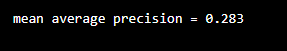

In [ ]:
#guardamos en modelo en formato pk
import joblib  
joblib.dump(model, '/content/drive/MyDrive/Data Science - TP4/datos Proyecto/lightfmTextMinigEquipo3.pkl')

['/content/drive/MyDrive/Data Science - TP4/datos Proyecto/lightfmTextMinigEquipo3.pkl']

si comparamos este modeo con los  otros, podemos concluir que este es ligeramente mejor, por lo tanto, lo seleccionaremos para ponerlo en produccion

In [ ]:
del vistacsr,test,activos

ahora, realizaremos el un breve post train con el modelo seleccionado, para poder preparar las recomendaciones que vamos a cunsumir 

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
setCorridas=pd.read_csv('/content/drive/MyDrive/Data Science - TP4/datos Proyecto/CorridaRecomendacionFinal.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


seleccionamos solo 100 usuarios aletoriamente  por tema de recursos, para crear la base que desplegara el modelo de recomendacion

In [ ]:
setCorridas=setCorridas[setCorridas.id_unico.isin(setCorridas.id_unico.sample(100))]

In [ ]:
setCorridas=setCorridas.drop(columns=['Unnamed: 0'])

In [ ]:
#al ser el modelo elegido, preparamos datos para extraer las recomendaciones
activos=pd.read_csv('/content/drive/MyDrive/Data Science - TP4/datos Proyecto/metadata.csv',sep=";")
activos.content_id=activos.content_id.dropna().astype(int).astype(str)
activos.content_id=activos.content_id.fillna(0).astype(int)
activos=activos.drop_duplicates(subset=['content_id','asset_id'])
#necesitamos columnas que nos permitan ordenar los activos recomendados para mostrar al usuario
#por lo tanto, las creamos usando expresiones regulares en titulo reducido del set de activos
activos['tieneTemporada']=activos.reduced_title.str.upper().str.strip().str.extract(r'([_T])(\d+)')[0].fillna(0).replace('T',1).replace('_',0).astype(int)
activos['temporadaNumero']=activos.reduced_title.str.upper().str.strip().str.extract(r'([_T])(\d+)')[1].fillna(0).astype(int)
activos['temporadaNumero']=activos['temporadaNumero']*activos['tieneTemporada']
activos['tieneEpisodio']=activos.reduced_title.str.upper().str.strip().str.extract(r'([_E])(\d+)')[0].fillna(0).replace('E',1).replace('_',0).astype(int)
activos['episodioNumero']=activos.reduced_title.str.upper().str.strip().str.extract(r'([_E])(\d+)')[1].fillna(0).astype(int)
activos['episodioNumero']=activos['episodioNumero']*activos['tieneEpisodio']
setCorridas=setCorridas.merge(activos[['content_id','asset_id','title','show_type','country_of_origin','category','released_year','audience','run_time_min','temporadaNumero','episodioNumero']],on='content_id')
#sacamos los asset_id que el ususario ya vio en el set de train
vistoscsr=pd.read_csv('/content/drive/MyDrive/Data Science - TP4/datos Proyecto/train.csv')
vistoscsr=vistoscsr[pd.to_datetime(vistoscsr.tunein).dt.month!=3]
vistoscsr.asset_id=vistoscsr.asset_id.astype(int)
setCorridas=setCorridas[~(setCorridas.asset_id.isin(vistoscsr.asset_id))]
del vistoscsr
setCorridas=setCorridas.sort_values(['content_id','temporadaNumero','episodioNumero'],ascending=True).reset_index().drop(columns='index').reset_index().rename(columns={'index':'ordenRecomendacion'})
#generamos particion de datos y guardamos resultados del modelo
setCorridas['partitionRows']=setCorridas.groupby(by=['id_unico','content_id'])['ordenRecomendacion'].rank(method='first')
setCorridas.partitionRows=setCorridas.partitionRows.astype(int)
del activos


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
setCorridas[(setCorridas['partitionRows']==1)]


,ordenRecomendacion,id_unico,content_id,asset_id,title,show_type,country_of_origin,category,released_year,audience,run_time_min,temporadaNumero,episodioNumero,partitionRows
0,0,3928558678,0,15032,Audios y Subtítulos,Tutorial,AR,Tutoriales/Decodificador Flow,2019.0,General,1.0,0,0,1
15,15,3048051100,0,15032,Audios y Subtítulos,Tutorial,AR,Tutoriales/Decodificador Flow,2019.0,General,1.0,0,0,1
30,30,4474663663,0,15032,Audios y Subtítulos,Tutorial,AR,Tutoriales/Decodificador Flow,2019.0,General,1.0,0,0,1
45,45,1727789545,0,15032,Audios y Subtítulos,Tutorial,AR,Tutoriales/Decodificador Flow,2019.0,General,1.0,0,0,1
60,60,6050378386,0,15032,Audios y Subtítulos,Tutorial,AR,Tutoriales/Decodificador Flow,2019.0,General,1.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186186,186186,5809476004,4306,816,Remake,Película,AR,Drama,2006.0,General,91.0,0,0,1
186187,186187,7001088420,4306,816,Remake,Película,AR,Drama,2006.0,General,91.0,0,0,1
186188,186188,5624374261,4306,816,Remake,Película,AR,Drama,2006.0,General,91.0,0,0,1
186189,186189,9691314214,4306,816,Remake,Película,AR,Drama,2006.0,General,91.0,0,0,1


guardamos el set preparado para poner el mismo en produccion 

In [ ]:
setCorridas.to_csv('/content/drive/MyDrive/Data Science - TP4/datos Proyecto/CorridaRecomendacion.csv')